<h1>Dataset Preprocessing to Enable Application of Classical ML Models</h1>

In [1]:
import json
from timeit import default_timer

In [2]:
import numpy as np
import tensorflow as tf

In [3]:
from model.model import build_preprocessing

In [4]:
# Load configuration file from json in the given folder
with open("config.json", "r") as config_file:
    config = json.load(config_file)

In [5]:
# Set up the list of gestures
with open(config["Paths"]["Gesture list"], "r") as gesture_list:
    gestures = gesture_list.readlines()[0].split(", ")

In [6]:
img_size = config["General parameters"]["Image size"]

In [7]:
train_images, test_images = tf.keras.preprocessing.image_dataset_from_directory("Data",
                                                                                labels="inferred",
                                                                                label_mode="int",
                                                                                class_names=gestures,
                                                                                color_mode="rgb",
                                                                                batch_size=32,
                                                                                image_size=(img_size,
                                                                                            img_size),
                                                                                shuffle=True,
                                                                                seed=12,
                                                                                validation_split=0.3,
                                                                                subset="both")

Found 94519 files belonging to 49 classes.
Using 66164 files for training.
Using 28355 files for validation.


In [45]:
import matplotlib.pyplot as plt
import time

In [8]:
from sklearn.metrics import classification_report

In [9]:
from model.preprocessing import Grayscale, AdaptiveThresholding

In [10]:
model = tf.keras.models.load_model(filepath=config["Model"]["Current model"],
                                   custom_objects={"AdaptiveThresholding": AdaptiveThresholding,
                                                   "Grayscale": Grayscale})

In [14]:
predictions = model.predict(test_images.map(lambda x, y: x, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True).take(50))

50/50 [==============================] - 24s 480ms/step


In [54]:
predictions_argmaxed = tf.argmax(predictions, axis=1).numpy()

In [15]:
test_y = list(test_images.map(lambda x, y: y, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True).take(50).unbatch().as_numpy_iterator())

In [16]:
report =  classification_report(test_y,
                                tf.argmax(predictions, axis=1).numpy(),
                                target_names=gestures)

In [17]:
print(report)

              precision    recall  f1-score   support

     I index       1.00      1.00      1.00        33
          My       1.00      1.00      1.00        38
         You       1.00      0.97      0.98        30
        Your       0.97      1.00      0.98        28
          In       1.00      1.00      1.00        40
          To       1.00      1.00      1.00        39
        With       0.96      1.00      0.98        24
         Yes       0.98      1.00      0.99        44
          No       1.00      1.00      1.00        31
        Well       1.00      1.00      1.00        26
  I love you       1.00      1.00      1.00        30
    Oh I see       1.00      1.00      1.00        21
        Name       1.00      1.00      1.00        32
         Hug       1.00      1.00      1.00        28
    Internet       1.00      1.00      1.00        24
         Bus       1.00      1.00      1.00        45
       Money       1.00      1.00      1.00        30
        Work       1.00    

In [56]:
(test_y != predictions_argmaxed).nonzero()[0]

array([  17,   53,  105,  167,  198,  308,  418,  463,  580,  713,  720,
        766,  825,  891, 1038, 1175, 1230, 1347, 1501, 1548, 1573, 1598],
      dtype=int64)

In [57]:
wrong_indices = (test_y != predictions_argmaxed).nonzero()[0]
wrong_imgs = []
for i, img in enumerate(test_images.map(lambda x, y: x, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True).unbatch().as_numpy_iterator()):
    if i in wrong_indices:
        wrong_imgs.append(img.astype("uint8"))

Model prediction:  N
Actual label:  T


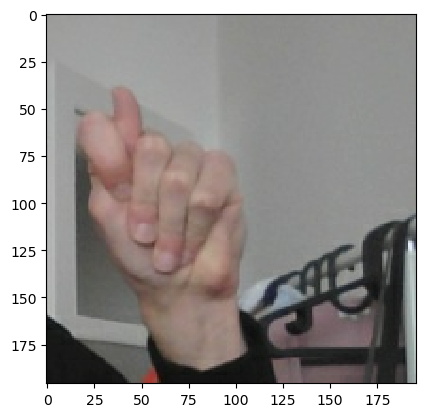

Model prediction:  Q
Actual label:  Look


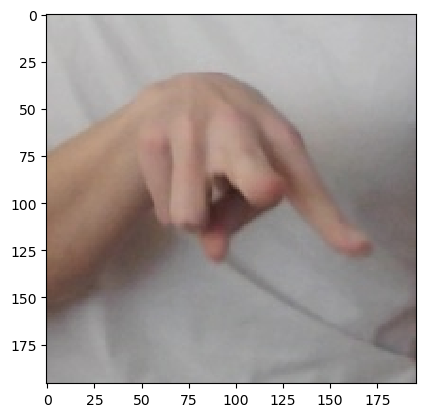

Model prediction:  No
Actual label:  T


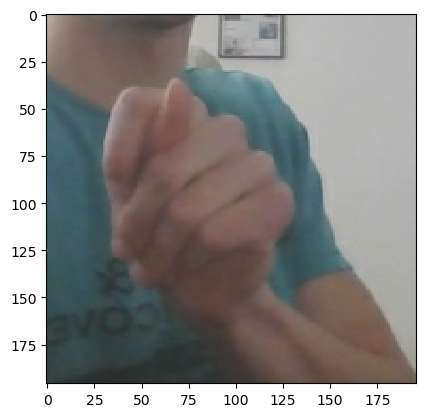

Model prediction:  A
Actual label:  Ask


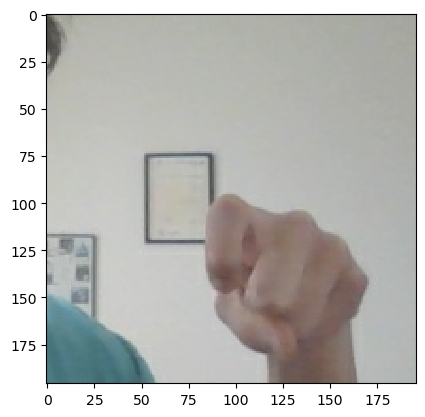

Model prediction:  Y
Actual label:  M


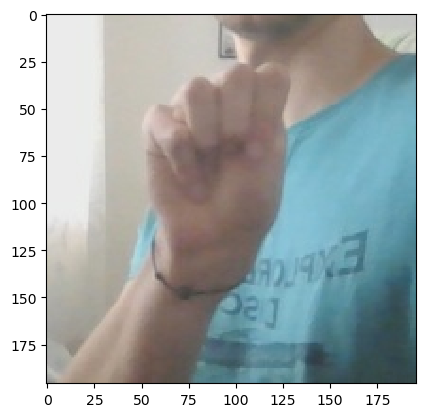

Model prediction:  S
Actual label:  M


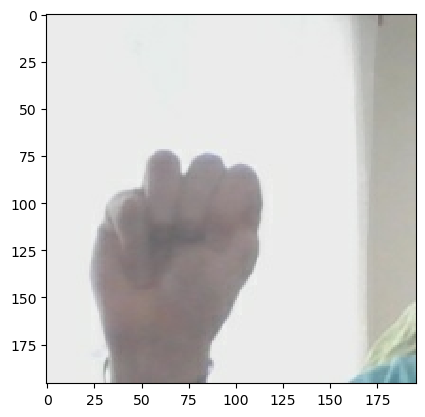

Model prediction:  M
Actual label:  No


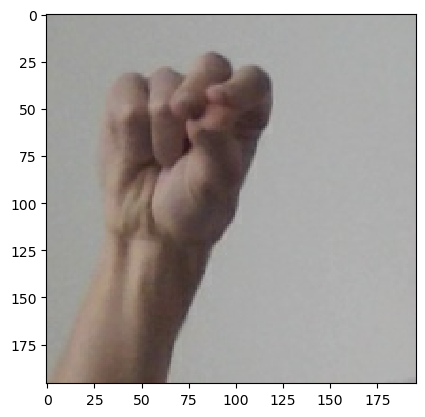

Model prediction:  G
Actual label:  Look


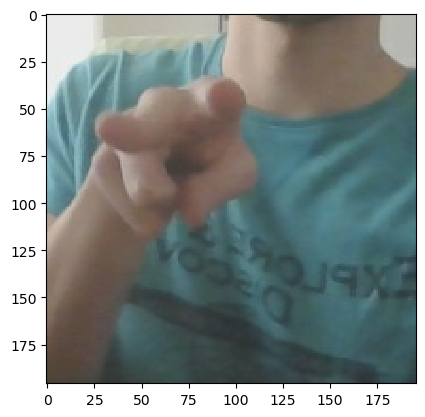

Model prediction:  M
Actual label:  A


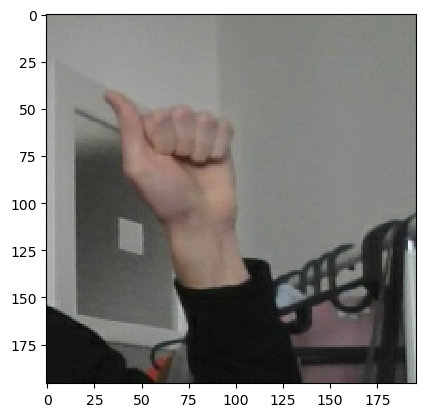

Model prediction:  Your
Actual label:  F


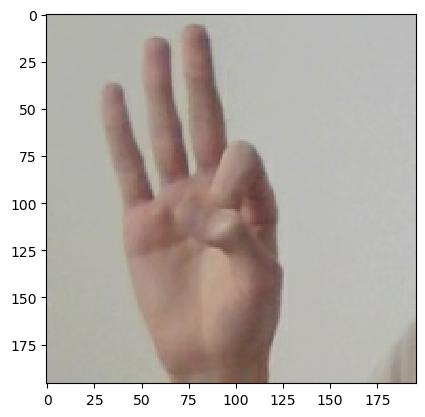

Model prediction:  N
Actual label:  T


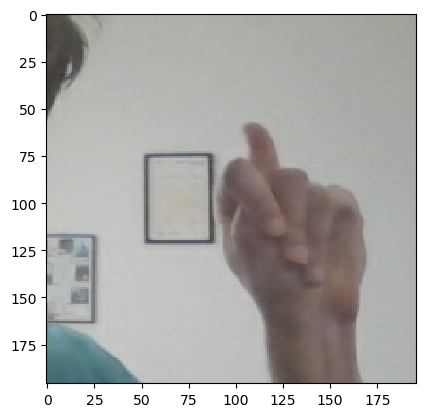

Model prediction:  No
Actual label:  M


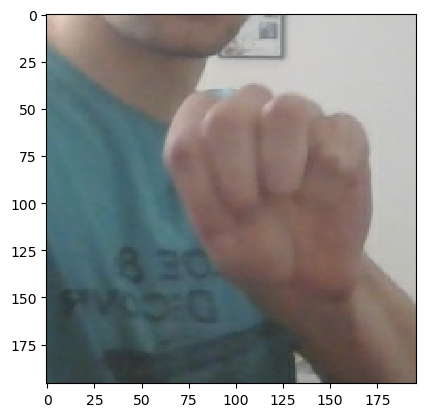

Model prediction:  M
Actual label:  A


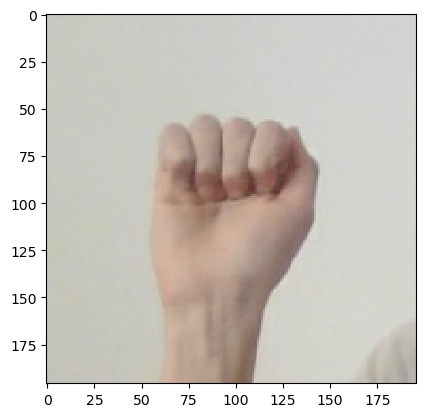

Model prediction:  C
Actual label:  You


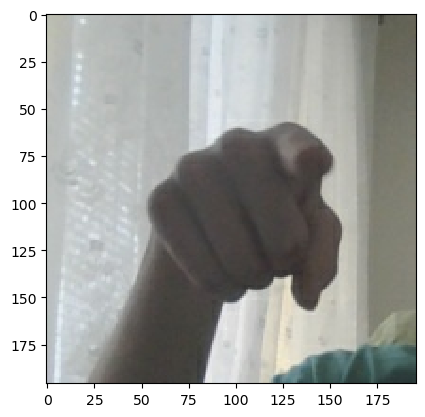

Model prediction:  Ask
Actual label:  You


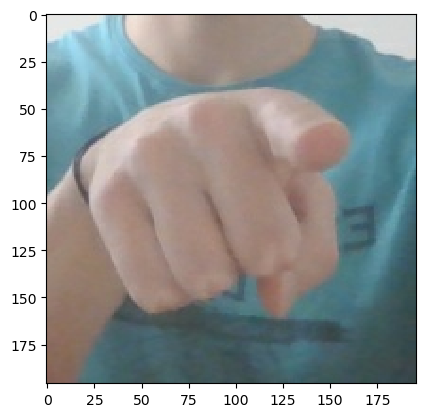

Model prediction:  D
Actual label:  T


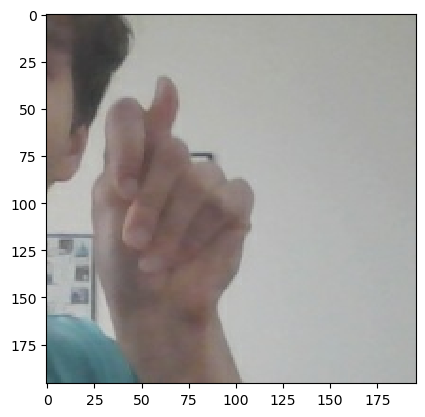

Model prediction:  U
Actual label:  T


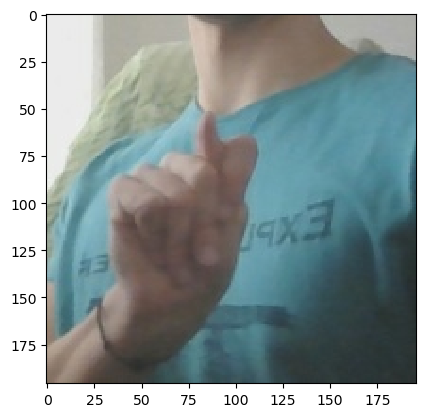

Model prediction:  Ask
Actual label:  A


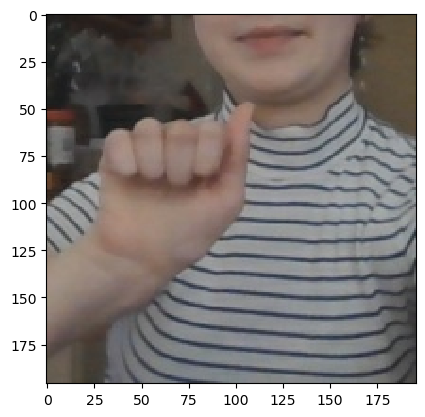

Model prediction:  T
Actual label:  Ask


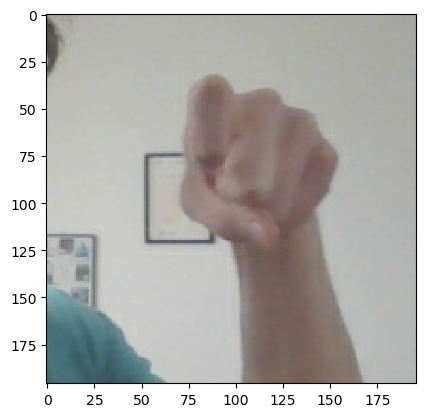

Model prediction:  C
Actual label:  M


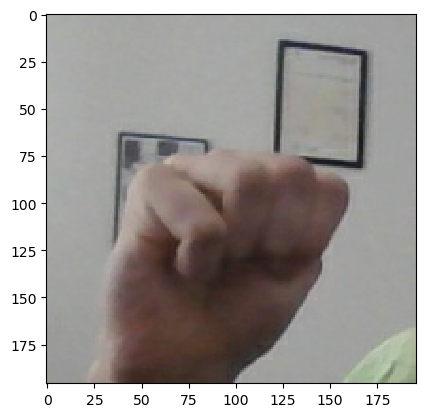

Model prediction:  P
Actual label:  Look


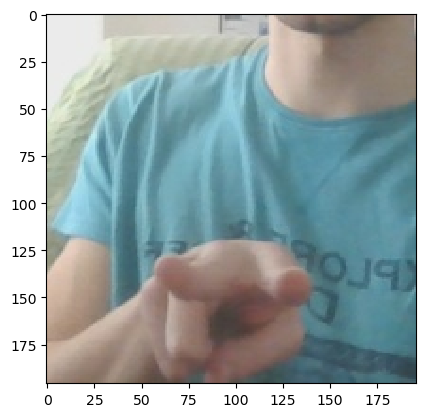

Model prediction:  Internet
Actual label:  M


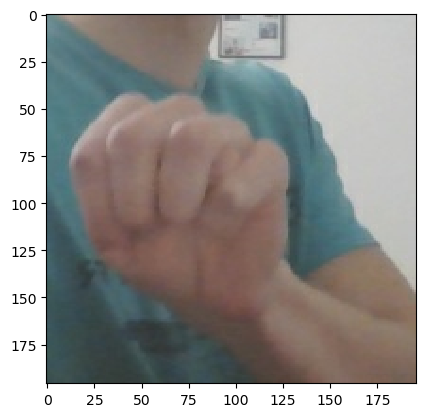

In [58]:
for ind, img in zip(wrong_indices, wrong_imgs):
    print("Model prediction: ", gestures[predictions_argmaxed[ind]])
    print("Actual label: ", gestures[test_y[ind]])
    plt.imshow(img, interpolation="nearest")
    plt.show()
    time.sleep(0.5)

In [11]:
# Set the default preprocessing pipeline if not specified
preprocessing_layers = config["Model"]["Default preprocessing"]
preprocessing_layers = "I,G,R"

# Build the preprocessing pipeline according to given instructions
preprocessing = build_preprocessing(inp_shape=[img_size,
                                               img_size,
                                               3],
                                    instructions=preprocessing_layers,
                                    name="preprocessing_pipeline")

In [9]:
# Apply the same preprocessing steps as for the CNN but flatten the images
channels = 1 if "G" in preprocessing_layers else 3
train_images = train_images.map(lambda x, y: (tf.reshape(preprocessing(x), [-1, img_size ** 2 * channels]), y), num_parallel_calls=tf.data.AUTOTUNE, deterministic=True).unbatch()
test_images = test_images.map(lambda x, y: (tf.reshape(preprocessing(x), [-1, img_size ** 2 * channels]), y), num_parallel_calls=tf.data.AUTOTUNE, deterministic=True).unbatch()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [10]:
# Convert the tf.data.Datasets to numpy arrays containing image & label per sample
train_images = np.array(list(train_images.as_numpy_iterator()), dtype=tuple)
test_images = np.array(list(test_images.as_numpy_iterator()), dtype=tuple)

In [11]:
# Extract the images and the labels separately
train_X, train_y = np.array([element[0] for element in train_images]), np.ravel(np.vstack([element[1] for element in train_images]))
test_X, test_y = np.array([element[0] for element in test_images]), np.ravel(np.vstack([element[1] for element in test_images]))

MemoryError: Unable to allocate 9.34 GiB for an array with shape (65268, 38416) and data type float32

In [ ]:
# Check memory consumption for the training dataset
print("Training dataset memory consumption: {:.1f}MB".format(train_X.nbytes / (1024 * 1024.0)))

<h1>k-NN Gesture Classification</h1>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

In [ ]:
# Initialize and train the k-NN classifier with parameters obtained from grid search
knn = KNeighborsClassifier(n_neighbors=3,
                           p=2,
                           n_jobs=-1)
knn.fit(train_X, train_y)

In [ ]:
# Evaluate the classifier on the test dataset
start = default_timer()
knn_predictions = knn.predict(test_X)

print("Time per gesture:", str(round((default_timer() - start) / (test_X.shape[0]), 5)) + " s")
print("Accuracy:", accuracy_score(test_y, knn_predictions))
print(classification_report(test_y,
                            knn_predictions,
                            target_names=gestures))

In [ ]:
np.unique(knn_predictions, return_counts=True)

In [ ]:
np.unique(test_y, return_counts=True)

<h1>Decision Tree Gesture Classification</h1>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

In [ ]:
# Initialize and train the Random Forest classifier with parameters obtained from grid search
rfc = RandomForestClassifier(n_estimators=100,
                             max_depth=55,
                             min_samples_split=5,
                             n_jobs=-1)
rfc.fit(train_X, train_y)

In [ ]:
# Evaluate the classifier on the test dataset
start = default_timer()
rfc_predictions = rfc.predict(test_X)

print("Time per gesture:", str(round((default_timer() - start) / (test_X.shape[0]), 6)) + " s")
print("Accuracy:", accuracy_score(test_y, rfc_predictions))
print(classification_report(test_y,
                            rfc_predictions,
                            target_names=gestures))

In [ ]:
np.unique(rfc_predictions, return_counts=True)

In [ ]:
np.unique(test_y, return_counts=True)

<h1>Real-time Analysis</h1>

In [ ]:
import os
import re
import warnings
import numpy as np
import cv2
import tensorflow as tf
from timeit import default_timer
from utils import create_rectangle, get_dictionary


def showcase_model(gesture_list, examples="Examples", predict=False,
                   model=None, translations="translations.txt", img_size=196):

    # The rectangle in the frame that is cropped from the web camera image
    # (one for torso location, one for fingerspelling location)
    rect_size = int(img_size * 1.25) + 4
    rect_torso = create_rectangle((225, 225), rect_size, rect_size)
    rect_fingerspell_1 = create_rectangle((50, 50), rect_size, rect_size)
    rect_fingerspell_2 = create_rectangle((350, 50), rect_size, rect_size)
    rect = rect_torso

    # Naive solution to allow looping through the gestures in prediction environment

    # Encapsulate the whole process to be able to close cameras in case of error
    try:

        cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)

        # Establish the windows and place them accordingly
        cv2.namedWindow("Camera view")
        cv2.resizeWindow("Camera view", 800, 600)
        cv2.moveWindow("Camera view", 25, 150)

        cv2.namedWindow("Example")
        cv2.resizeWindow("Example", 640, 480)
        cv2.moveWindow("Example", 850, 230)

        lang = True  # To let the user change language, True stands for English, False for Czech
        rectangle_position = 0  # Which position of the rectangle to use
        pause_flag = False  # Enable the user to pause the process

        # Perform the data collecting process for each gesture in the given gesture list
        for gesture in gesture_list:

            # Initialize necessary variables (different per gesture)
            flag = 0  # To know when a new gesture is being taken for the first time
            exit_flag = 0  # To let the user end the process early by clicking the "Esc" key

            # Continue until the user terminates the process
            while True:
                ret, frame = cap.read()

                # Check validity and avoid mirroring if frame is present
                if not ret:
                    print("There has been a problem retrieving your frame")
                    print("Try adjusting the camera number in specification of cap (default 0)")
                    break
                frame = cv2.flip(frame, 1)

                # End the process for the current gesture in case the "q" key is hit
                key = cv2.waitKey(1)
                if key == ord("q"):
                    break

                # End the whole process in case the "Esc" key is hit
                if key == ord("\x1b"):
                    exit_flag = 1
                    break

                # Change language settings in case the "l" key is hit
                if key == ord("l"):
                    lang = not lang

                # Pause the process if the "p" key is hit
                if key == ord("p"):
                    pause_flag = not pause_flag

                # Change the rectangle position if the "spacebar" key is hit
                if key == ord(" "):
                    rectangle_position += 1
                    rect = [rect_torso, rect_fingerspell_1, rect_fingerspell_2][rectangle_position % 3]

                # Create rectangle cut
                frame_cut = frame[(rect[0][1] + 2):(rect[2][1] - 2),
                                  (rect[0][0] + 2):(rect[1][0] - 2)]
                frame_cut = cv2.resize(frame_cut, (img_size, img_size))

                # Adjust the color of the text and frame based on the current state
                # Green - running model prediction, Orange - model prediction is paused
                if pause_flag:
                    color = (0, 128, 255)
                else:
                    color = (0, 255, 0)

                # Live view with frame and text (colorcoded as specified above)
                cv2.rectangle(frame, rect[0], rect[3], color, 2)
                # Add information about prediction if expected, otherwise just show the name of the gesture
                if predict and not pause_flag:
                    pred_time_start = default_timer()
                    predict_frame = np.reshape(preprocessing(resize(frame_cut[None, :])).numpy()[0, :, :, 0], [1, -1])
                    prediction = model.predict(predict_frame)
                    #probability = prediction.max(axis=-1).round(2)
                    txt = gesture_list[prediction[0]]
                    pred_time = round(default_timer() - pred_time_start, 3)
                    if not lang:
                        txt = dictionary[txt]
                    #txt += " (" + str(probability[0]) + ")"

                    # Display average time per gesture
                    cv2.putText(frame, "TPG: " + str(pred_time) + " s", (5, 470),
                                cv2.FONT_HERSHEY_DUPLEX, 0.8, color, 2)
                else:
                    txt = gesture
                    if not lang:
                        txt = dictionary[txt]
                cv2.putText(frame, txt, (rect[0][0], rect[0][1] - 15),
                            cv2.FONT_HERSHEY_DUPLEX, 1, color, 2)
                cv2.imshow("Camera view", cv2.resize(frame, (800, 600)))

                # Show example on new gesture
                if not flag:
                    example = cv2.imread(f"{os.path.join(examples, gesture)}" + ".jpg")
                    cv2.imshow("Example", cv2.resize(example, (640, 480)))
                    flag = 1

            if exit_flag:
                break

    # Close the camera and all windows in case of unexpected fatality
    finally:
        cap.release()
        cv2.destroyAllWindows()

In [ ]:
gestures = "I index, My, You, Your, In, To, With, Yes, No, Well, I love you, Oh I see, Name, Hug, Internet, Bus, Money, Work, Ask, Go, Look, Have, Correct, Want, A, B, C, D, E, F, G, H, I, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, N-A".split(", ")

In [ ]:
showcase_model(gestures, predict=True, model=knn)